In [1]:
%matplotlib inline
import ipykernel
import numpy as np
from astropy.io import fits
import astropy.units as units
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import rc
from scipy.interpolate import interp1d
from scipy import stats
from matplotlib.colors import LogNorm

from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler
from scipy import sparse
from sklearn.mixture import GMM

In [2]:
rc('text', usetex= True)
rc('font', family='serif', weight = 'normal', size=15)
rc('xtick.major', size='6')
rc('xtick.minor', size='4')
rc('ytick.major', size='6')
rc('ytick.minor', size='4')
rc('lines', linewidth=1.5)
rc('axes', linewidth=1.5)
rc('axes', facecolor='f9f9f9')
rc('axes', axisbelow=True)
rc('xtick', direction='in')
rc('ytick', direction='in')
rc('grid', color='cbcbcb')
rc('grid', linestyle='-')
rc('grid', linewidth=0.5)
rc('grid', alpha=1.0)
rc('figure', facecolor='ffffff')
rc('figure', dpi=80)
rc('figure.subplot', bottom=0.125)


# Purpose


1) Make Fig. 3.
   Fig.3 shows the sources with small proper motions, in three different parallax intervals.

2) KDE + bootstrapping to make Fig. 5.

## Figure 3.


In [3]:
path = '/data1/Data/TGAS/ZariOrion-result/'
ori = fits.open(path + 'data')
tgas = ori[1].data

            
tgas = tgas[~np.isnan(tgas['parallax'])]
center = np.array([1., -0.5])
tgasProperMotionSelection = np.where((tgas['pmra'] - center[0])**2. + (tgas['pmdec']-center[1])**2 < 25.)
tgasProperMotion = tgas[tgasProperMotionSelection]
tgasPlx = tgasProperMotion[(tgasProperMotion['parallax'] >= 2.) & (tgasProperMotion['parallax'] <= 3.5)]

In [4]:
plx1 = tgasProperMotion[(tgasProperMotion['parallax'] >= 0.) & (tgasProperMotion['parallax'] <= 2.)]
plx2 = tgasProperMotion[(tgasProperMotion['parallax'] >= 2.) & (tgasProperMotion['parallax'] <= 3.5)]
plx3 = tgasProperMotion[(tgasProperMotion['parallax'] >= 3.5)]

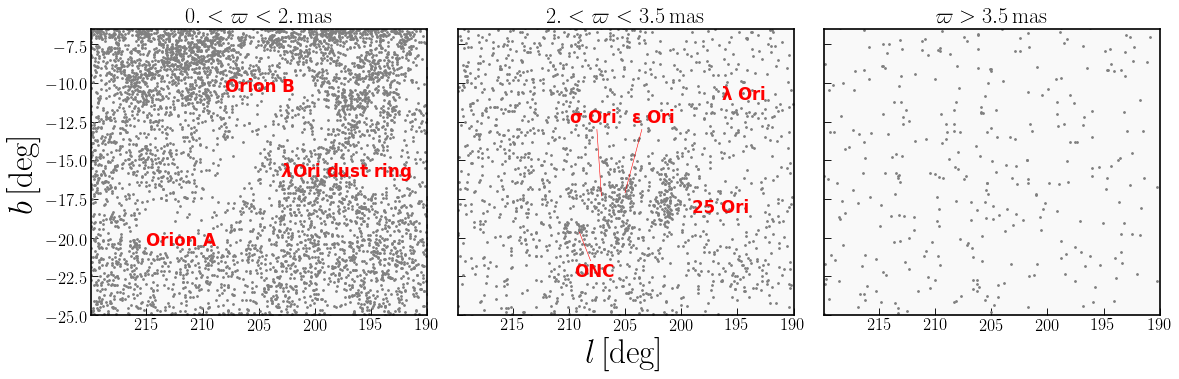

In [5]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.1)

ax1 = plt.subplot(131)
plt.plot(plx1['l'], plx1['b'], 'o', color = 'gray', ms = 1.5)
plt.axis([219.9, 190, -25, -5])
rc('text', usetex= False)
rc('font', family='sans-serif', weight = 'bold', size=15)
plt.text(208, -10.5, 'Orion B', color= 'r')
plt.text(215, -20.5, 'Orion A', color= 'r')
plt.text(203, -16., r'$\lambda$Ori dust ring', color= 'r')

rc('text', usetex= True)
plt.title(r'$0. < \varpi < 2. \, \mathrm{mas}$', fontsize = 20, family = 'serif')
plt.ylabel(r'$b \mathrm{ \, [deg]}$', fontsize = 30)

ax2 = plt.subplot(132, sharey=ax1)
plt.plot(plx2['l'], plx2['b'], 'o', color = 'gray', ms = 1.5)


rc('text', usetex= False)
rc('font', family='sans-serif', weight = 'bold', size=15)
plt.text(199, -18.35, '25 Ori', color= 'r', fontsize = 15, family ='sans-serif')
plt.text(204.5, -12.5, '$\mathrm{\epsilon}$ Ori', color = 'r', fontsize = 15, family ='sans-serif')
plt.plot([203.5, 205.],[-13., -17.1], 'r-', lw = 0.5)
plt.text(210, -12.5, '$\mathrm{\sigma}$ Ori', color = 'r', fontsize = 15, family ='sans-serif')
plt.plot([207.5, 207.1], [-13, -17.31], 'r-', lw = 0.5)
plt.text(196.5, -11. , '$\mathrm{\lambda}$ Ori', color = 'r', fontsize = 15, family ='sans-serif')
plt.text(209.5, -22.5, 'ONC', color= 'r',fontsize = 15, family ='sans-serif')
plt.plot([208.06, 209.06], [-21.5, -19.65], 'r-', lw = 0.5)

rc('text', usetex= True)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.axis([219.9, 190, -25, -5])
plt.title(r'$2. < \varpi < 3.5 \, \mathrm{mas}$', fontsize = 20)
plt.xlabel(r'$l \mathrm{\, [deg]}$', fontsize = 30)

ax3 = plt.subplot(133, sharey =ax1)
plt.plot(plx3['l'], plx3['b'], 'o', color= 'gray', ms = 1.5)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.axis([219.9, 190, -25, -6.5])
plt.title(r'$ \varpi > 3.5 \, \mathrm{mas}$', fontsize = 20)

plt.tight_layout()

## KDE of Fig. 5

Here I upload the sources with S = 3 of the TGAS KDE.

In [6]:
tgasInHDU = fits.open('/data1/Data/Gaia/kdeSelectionSigGT3TGAS.fits')
tgasIn = tgasInHDU[1].data

In [7]:
plxIn = tgasIn['parallax']
e_plxIn = tgasIn['parallax_error']

In [8]:
X = plxIn[:, np.newaxis]
X_plot = np.linspace(1.9, 3.6, 1000)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.03).fit(X)
log_dens = kde.score_samples(X_plot)

In [9]:
X2 = plx2['parallax']
X2 = X2[:, np.newaxis]
X_plot = np.linspace(1.9, 3.6, 1000)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.03).fit(X2)
log_dens2 = kde.score_samples(X_plot)

#### What's the optimal bandwidth?
In the Machine Learning world an empirical approach such as cross validation is often used. In cross validation, the model is fit to part of the data, and then a quantitative metric is computed to determine how well this model fits the remaining data. Such an empirical approach to model parameter selection is very flexible, and can be used regardless of the underlying data distribution.
Because the various reference rules generally depend on (often dubious) assumptions about the underlying distribution of the data, bandwidth selection based in cross-validation can produce more trustworthy results for real-world datasets. A leave-one-out cross-validation scheme is built-in to the Statsmodels KDEMultivariate class. For large datasets, however, leave-one-out cross-validation can be extremely slow. Scikit-learn does not currently provide built-in cross validation within the KernelDensity estimator, but the standard cross validation tools within the module can be applied quite easily, as shown in the example below.

In [10]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 1., 50)},
                    cv=20) # 20-fold cross-validation
grid.fit(X)
print( grid.best_params_)


{'bandwidth': 0.030204081632653063}


### Bayesian Blocks

See https://jakevdp.github.io/blog/2012/09/12/dynamic-programming-in-python/ for a broad discussion on Bayesian Blocks, and some examples.

In [22]:
binsB = bayesian_blocks(plxIn)
binsB2 = bayesian_blocks(plx2['parallax'])


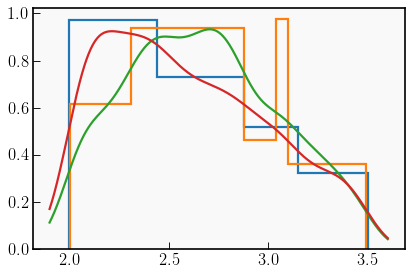

In [30]:
#plt.hist(plxIn, bins = 20, histtype='step', normed = True, lw =2)
plt.hist(plx2['parallax'], bins = binsB2, histtype='step', normed = True, lw =2)
plt.hist(plxIn, bins = binsB, histtype='step', normed = True, lw =2)
plt.plot(X_plot, np.exp(log_dens), lw =2)
plt.plot(X_plot, np.exp(log_dens2),lw =2 )

plt.show()

In [11]:
def bayesian_blocks(t):
    """Bayesian Blocks Implementation

    By Jake Vanderplas.  License: BSD
    Based on algorithm outlined in http://adsabs.harvard.edu/abs/2012arXiv1207.5578S

    Parameters
    ----------
    t : ndarray, length N
        data to be histogrammed

    Returns
    -------
    bins : ndarray
        array containing the (N+1) bin edges

    Notes
    -----
    This is an incomplete implementation: it may fail for some
    datasets.  Alternate fitness functions and prior forms can
    be found in the paper listed above.
    """
    # copy and sort the array
    t = np.sort(t)
    N = t.size

    # create length-(N + 1) array of cell edges
    edges = np.concatenate([t[:1],
                            0.5 * (t[1:] + t[:-1]),
                            t[-1:]])
    block_length = t[-1] - edges

    # arrays needed for the iteration
    nn_vec = np.ones(N)
    best = np.zeros(N, dtype=float)
    last = np.zeros(N, dtype=int)

    #-----------------------------------------------------------------
    # Start with first data cell; add one cell at each iteration
    #-----------------------------------------------------------------
    for K in range(N):
        # Compute the width and count of the final bin for all possible
        # locations of the K^th changepoint
        width = block_length[:K + 1] - block_length[K + 1]
        count_vec = np.cumsum(nn_vec[:K + 1][::-1])[::-1]

        # evaluate fitness function for these possibilities
        fit_vec = count_vec * (np.log(count_vec) - np.log(width))
        fit_vec -= 4  # 4 comes from the prior on the number of changepoints
        fit_vec[1:] += best[:K]

        # find the max of the fitness: this is the K^th changepoint
        i_max = np.argmax(fit_vec)
        last[K] = i_max
        best[K] = fit_vec[i_max]

    #-----------------------------------------------------------------
    # Recover changepoints by iteratively peeling off the last block
    #-----------------------------------------------------------------
    change_points =  np.zeros(N, dtype=int)
    i_cp = N
    ind = N
    while True:
        i_cp -= 1
        change_points[i_cp] = ind
        if ind == 0:
            break
        ind = last[ind - 1]
    change_points = change_points[i_cp:]

    return edges[change_points]

### Bootstrapping

In [12]:
N = 1000
newParallaxDistrib = np.zeros((len(plxIn), N))
for i in range(N):
    for k in range(len(plxIn)):
        newParallaxDistrib[k, i] = np.random.normal(plxIn[k], e_plxIn[k])
        

In [13]:
N = 1000
plx = plx2['parallax']
e_plx = plx2['parallax_error']
newParallaxDistrib_Field = np.zeros((len(plx), N))
for i in range(N):
    for k in range(len(plx)):
        newParallaxDistrib_Field[k, i] = np.random.normal(plx[k], e_plx[k])


Compute the KDE's for all of the distributions, than median and percentiles.


In [19]:
log_dens_new = []
for i in range(N):
    X = newParallaxDistrib[:, i][:, np.newaxis]
    X_plot_new = np.linspace(2., 3.5, 100)[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=0.03).fit(X)
    log_dens_new.append(kde.score_samples(X_plot_new)) 

In [15]:
log_dens_field = []
for i in range(N):
    X = newParallaxDistrib_Field[:, i][:, np.newaxis]
    X_plot_new_field = np.linspace(1., 5, 100)[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=0.03).fit(X)
    log_dens_field.append(kde.score_samples(X_plot_new)) 

In [20]:
avg_log_dens = np.mean(np.exp(log_dens_new), axis = 0)
avg_log_dens_field = np.mean(np.exp(log_dens_field), axis = 0)
median_log_dens = np.median(np.exp(log_dens_new), axis = 0)
percentile95 = np.percentile(np.exp(log_dens_new), 84, axis = 0)
percentile05 = np.percentile(np.exp(log_dens_new), 16, axis = 0)

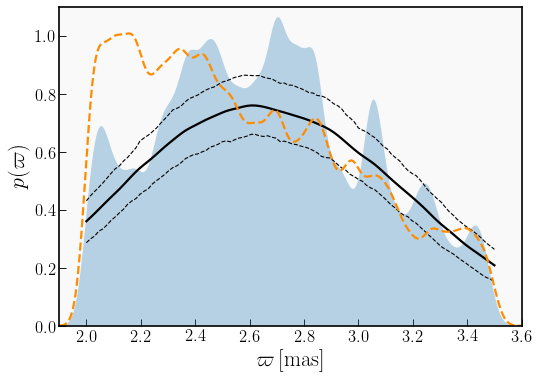

In [21]:
plt.figure(figsize=(7, 5))

plt.fill_between(X_plot[:,0], np.exp(log_dens), 0., alpha =0.3)
plt.plot(X_plot_new, percentile05, '--', lw =1, color='k')
plt.plot(X_plot_new, percentile95, '--', lw =1, color='k')
plt.plot(X_plot_new, avg_log_dens, '-', lw =2, color = 'k')
plt.plot(X_plot, np.exp(log_dens2), ls = '--',lw =2, color = 'DarkOrange' )
#plt.plot(X_plot_new_field, avg_log_dens_field, ls = '-',lw =2, color = 'DarkOrange' )
plt.tight_layout()
plt.xlabel(r'$\varpi \, \mathrm{[mas]}$', fontsize = 20)
plt.ylabel(r'$p(\varpi) $', fontsize = 20)

plt.axis([1.9, 3.6, 0., 1.1])
plt.tight_layout()
